In [1]:
import pystac
import stac2dcache

import xml.etree.ElementTree as ET

from stac2dcache.utils import copy_asset, get_asset, catalog2geopandas 
from eratosthenes.postprocessing.solar_tools import make_shading

# Coregister images with Arosics

In [2]:
# the dcache API URL is not needed to download/upload data
# DCACHE_API_URL = "https://dcacheview.grid.surfsara.nl:22880/api/v1"
DCACHE_WEBDAV_URL = "https://webdav.grid.surfsara.nl:2880"

In [3]:
dcache_root = (DCACHE_WEBDAV_URL  
    + "/pnfs/grid.sara.nl/data/eratosthenes/disk/")

# path to raster DEM 
tile_id = "5VMG"
dem_url = dcache_root + f"ArcticDEM_tiles_sentinel-2/{tile_id}.tif"

# catalog with shadow-enhanced images
catalog_id = "red-glacier_sentinel-2_shadows"
catalog_url = dcache_root + catalog_id

# bounds
bbox = (494228.19, 6646652.01, 512136.52, 6656488.90)

In [4]:
# configure connection to dCache
dcache = stac2dcache.configure(
    filesystem="dcache", 
    token_filename="macaroon.dat"
)
# dcache.api_url = DCACHE_API_URL

In [5]:
def read_catalog(url):
    """
    Read STAC catalog from URL
    
    :param url: urlpath to the catalog root
    :return: PySTAC Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url)
    return catalog

In [6]:
# read image catalog
catalog = read_catalog(catalog_url)

In [7]:
items = catalog.get_all_items()

In [8]:
item = next(items)

In [9]:
link = item.get_links("computed_from").pop()
scene_item = link.resolve_stac_object().target
scene_item

<Item id=S2B_5VMG_20210326_0_L1C>

In [10]:
shadow = get_asset(
    catalog,
    asset_key="shadow",
    item_id=item.id,
    filesystem=dcache
)

In [11]:
shadow = shadow.squeeze()
shadow

<xarray.DataArray (y: 984, x: 1553)>
array([[0.92313697, 0.92660488, 0.93051822, ..., 0.1001129 , 0.22803161,
        0.20162303],
       [0.92507218, 0.92370764, 0.92255341, ..., 0.10149406, 0.20031211,
        0.29937842],
       [0.92663661, 0.92492   , 0.92344296, ..., 0.0336457 , 0.14565633,
        0.38316249],
       ...,
       [0.05084327, 0.04170608, 0.05859103, ..., 0.92168011, 0.92741353,
        0.93114467],
       [0.0114759 , 0.02086172, 0.04095467, ..., 0.92033969, 0.92637953,
        0.92555229],
       [0.01835552, 0.02616163, 0.04390395, ..., 0.91671379, 0.9245579 ,
        0.92410988]])
Coordinates:
    band         int64 1
  * y            (y) float64 6.656e+06 6.656e+06 ... 6.647e+06 6.647e+06
  * x            (x) float64 4.942e+05 4.942e+05 ... 5.097e+05 5.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

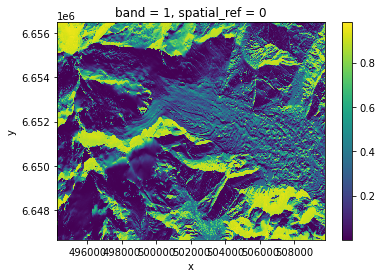

In [12]:
shadow.plot.imshow()

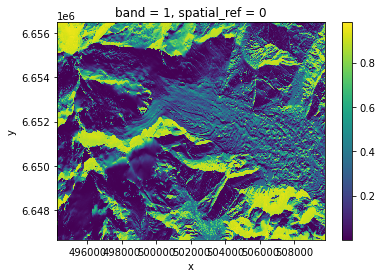

In [13]:
shadow_shifted = shadow.shift({'x': 6, 'y': 3}, fill_value=0)
shadow.plot.imshow()

In [14]:
import arosics

In [15]:
from geoarray import GeoArray
def dataarray_to_geoarray(da):
    """
    Convert rioxarray DataArray object to geoarray
    GeoArray object
    
    :param da: DataArray object
    :return: GeoArray object
    """
    return GeoArray(
        da.values,
        geotransform=da.rio.transform().to_gdal(),
        projection=da.rio.crs.to_wkt(),
        nodata=da.rio.nodata
    )

In [16]:
target = dataarray_to_geoarray(shadow)
reference = dataarray_to_geoarray(shadow_shifted)

In [18]:
coreg = arosics.COREG(reference, target, max_shift=10)
coreg.calculate_spatial_shifts()
shift = (coreg.x_shift_map, coreg.y_shift_map)
shift

Calculating actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(494230.0, 6646650.0, 509760.0, 6656490.0)
Calculating actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(494230.0, 6646650.0, 509760.0, 6656490.0)
Matching window position (X,Y): 501995.0/6651570.0
Detected integer shifts (X/Y):                            6/3
Detected subpixel shifts (X/Y):                           -1.7109212545549157e-11/-1.5339715212960194e-11
Calculated total shifts in fft pixel units (X/Y):         5.999999999982891/2.9999999999846603
Calculated total shifts in reference pixel units (X/Y):   5.999999999982891/2.9999999999846603
Calculated total shifts in target pixel units (X/Y):      5.999999999982891/2.9999999999846603
Calculated map shifts (X,Y):				  59.99999999982538/-30.0
Calculated absolute shift vector length in map units:     67.08203932483751
Calculated angle o

(59.99999999982538, -30.0)